## What Exactly Is Being Predicted?

**🔍 Primary Prediction:**  
The model estimates the **severity level of an accident** based on the **Season that includes time and day** plus **Location**.

---

### 📈 Insights Derived

- **🔄 Temporal Patterns:**  
  By aggregating predictions across different times, we can identify **peak hours** when severe accidents are more likely to occur.

- **🚑 Resource Allocation:**  
  Understanding the timing of severe accidents enables the **effective deployment of emergency services**, ensuring quicker response times during critical periods.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance



In [2]:
data = pd.read_excel("data/accidents.xlsx")
data

,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,Passengers,4,4.30 pm,NaN
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,Passengers,1,5.50 pm,NaN
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,Drivers/Occupants,4,NaN,NaN
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,Driver and passengers,3,6.00 pm,NaN
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,Pedestrian,1,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
76,2022-06-03,Losengeli,Sabatia,Vihiga,Nairobi Kakamega road,Bus lost control and rolled over,Passengers,1,NaN,NaN
77,2022-05-31,Isinya,Isinya,Kajiado,Namanga Road,Car rammed into a trailer,Passengers,1,11.00 pm,NaN
78,2022-05-30,Kinugi,Kinugi,Nakuru,Naivasha Nairobi Highway,Truck driver collided with an oncoming matatu,Passengers,1,NaN,NaN
79,2022-02-28,Kinugi,Kinugi,Nakuru,Nakuru - Nairobi highway,Car rammed into a lorry,Passengers,4,NaN,NaN


In [3]:
data.columns


Index(['Date', 'Accident Spot', 'Area', 'County', 'Road/ Highway',
       'Brief Accident Details/Cause', 'Victims',
       'Total people confirmed dead', 'Time of the Accidents',
       'Weather conditions'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Date                          80 non-null     datetime64[ns]
 1   Accident Spot                 81 non-null     object        
 2   Area                          81 non-null     object        
 3   County                        81 non-null     object        
 4   Road/ Highway                 80 non-null     object        
 5   Brief Accident Details/Cause  79 non-null     object        
 6   Victims                       63 non-null     object        
 7   Total people confirmed dead   72 non-null     object        
 8   Time of the Accidents         25 non-null     object        
 9   Weather conditions            1 non-null      object        
dtypes: datetime64[ns](1), object(9)
memory usage: 6.5+ KB


In [5]:
missing_values = data.isnull().sum()
percentage_missing = (missing_values/len(data))*100
print("Number of missing values each column\n", missing_values)
print("Percentages missing data in each column\n", percentage_missing)

Number of missing values each column
 Date                             1
Accident Spot                    0
Area                             0
County                           0
Road/ Highway                    1
Brief Accident Details/Cause     2
Victims                         18
Total people confirmed dead      9
Time of the Accidents           56
Weather conditions              80
dtype: int64
Percentages missing data in each column
 Date                             1.234568
Accident Spot                    0.000000
Area                             0.000000
County                           0.000000
Road/ Highway                    1.234568
Brief Accident Details/Cause     2.469136
Victims                         22.222222
Total people confirmed dead     11.111111
Time of the Accidents           69.135802
Weather conditions              98.765432
dtype: float64


In [1]:
# Convert Victims column to numeric, handling any non-numeric values
data['Victims'] = pd.to_numeric(data['Victims'], errors='coerce')
victims = data["Victims"]
print(victims.describe())



NameError: name 'pd' is not defined

In [7]:
# Convert time to 24hr format with minutes
def time_convert(time_str):
    try:
        if pd.isna(time_str):
            return None
        # Clean the time string
        time_str = str(time_str).strip().lower()
        
        # Handle AM/PM format
        if 'am' in time_str or 'pm' in time_str:
            try:
                # Try parsing with period separator
                dt = pd.to_datetime(time_str, format='%I.%M %p')
                return dt.hour * 60 + dt.minute
            except:
                try:
                    # Try parsing with colon separator
                    dt = pd.to_datetime(time_str, format='%I:%M %p')
                    return dt.hour * 60 + dt.minute
                except:
                    return None
        
        # Handle 24-hour format
        try:
            dt = pd.to_datetime(time_str, format='%H:%M')
            return dt.hour * 60 + dt.minute
        except:
            try:
                dt = pd.to_datetime(time_str, format='%H.%M')
                return dt.hour * 60 + dt.minute
            except:
                return None
    except:
        return None

# Create minutes since midnight column
data['minutes since midnight'] = data['Time of the Accidents'].apply(time_convert).ffill()

data




,Date,Accident Spot,Area,County,Road/ Highway,Brief Accident Details/Cause,Victims,Total people confirmed dead,Time of the Accidents,Weather conditions,minutes since midnight
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,Head on Collision,NaN,4,4.30 pm,NaN,990.0
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,vehicle and motorcycle collision,NaN,1,5.50 pm,NaN,1070.0
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,Head on Collision,NaN,4,NaN,NaN,1070.0
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,Head on Collision,NaN,3,6.00 pm,NaN,1080.0
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,Run over,NaN,1,NaN,NaN,1080.0
...,...,...,...,...,...,...,...,...,...,...,...
76,2022-06-03,Losengeli,Sabatia,Vihiga,Nairobi Kakamega road,Bus lost control and rolled over,NaN,1,NaN,NaN,840.0
77,2022-05-31,Isinya,Isinya,Kajiado,Namanga Road,Car rammed into a trailer,NaN,1,11.00 pm,NaN,1380.0
78,2022-05-30,Kinugi,Kinugi,Nakuru,Naivasha Nairobi Highway,Truck driver collided with an oncoming matatu,NaN,1,NaN,NaN,1380.0
79,2022-02-28,Kinugi,Kinugi,Nakuru,Nakuru - Nairobi highway,Car rammed into a lorry,NaN,4,NaN,NaN,1380.0


In [8]:
data['hour'] = data['minutes since midnight'] // 60
data['minute'] = data['minutes since midnight'] % 60
data['Date'] = pd.to_datetime(data['Date'])
data['day_of_week'] = data['Date'].dt.dayofweek  # Monday=0, Sunday=6
data['month'] = data['Date'].dt.month
data['season'] = data['Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, etc.



In [9]:
def data_prep(data):
    def danger_levels(deaths):
        if pd.isna(deaths):
            return 'Unknown'
        elif deaths == 0:
            return "No Fatality thus safe"
        elif deaths <= 2:
            return "Low Severity"
        elif deaths <= 5:
            return "Moderate Severity"
        else:
            return "High severity"
        
    data["Total people confirmed dead"] = pd.to_numeric(data["Total people confirmed dead"], errors="coerce")

    data["Severity Levels"] = data["Total people confirmed dead"].apply(danger_levels)

    # Prepare features (time-based)    
    X = data[['hour', 'minute', 'day_of_week', 'month', 'season']].copy()
        
    # Encode categorical target
    le_severity = LabelEncoder()
    y_severity = le_severity.fit_transform(data['Severity Levels'])

    le_road = LabelEncoder()
    y_road = le_road.fit_transform(data['Road/ Highway'])
    
    le_accident_spot = LabelEncoder()
    y_accident_spot = le_accident_spot.fit_transform(data['Accident Spot'])
    
    # Combine targets for multi-output
    y = pd.DataFrame({
        'accident_severity_encoded': y_severity,
        'Road_Highway_encoded': y_road,
        'Accident_Spot_encoded': y_accident_spot
    })

    return X, y, le_severity, le_road, le_accident_spot

In [10]:
#display current data state
columns_to_drop = ["Weather conditions", "minutes since midnight","Victims","Brief Accident Details/Cause"]

data.drop(columns_to_drop, axis=1)

,Date,Accident Spot,Area,County,Road/ Highway,Total people confirmed dead,Time of the Accidents,hour,minute,day_of_week,month,season
0,2023-08-08,Sobea,Sobea,Nakuru,Nakuru-Eldoret Highway,4,4.30 pm,16.0,30.0,1.0,8.0,3.0
1,2023-08-07,Maai-Mahiu,Naivasha,Nakuru,Maai-Mahiu Naivasha Highway,1,5.50 pm,17.0,50.0,0.0,8.0,3.0
2,2023-07-25,Ntulele,Ntulele,Narok,Narok Mai Mahiu road,4,NaN,17.0,50.0,1.0,7.0,3.0
3,2022-12-02,Suswa,Suswa,Narok,Narok Mai Mahiu road,3,6.00 pm,18.0,0.0,4.0,12.0,1.0
4,2022-12-01,Mutira,Mutira,Kirinyaga,Kerugoya-Karatina Road,1,NaN,18.0,0.0,3.0,12.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
76,2022-06-03,Losengeli,Sabatia,Vihiga,Nairobi Kakamega road,1,NaN,14.0,0.0,4.0,6.0,3.0
77,2022-05-31,Isinya,Isinya,Kajiado,Namanga Road,1,11.00 pm,23.0,0.0,1.0,5.0,2.0
78,2022-05-30,Kinugi,Kinugi,Nakuru,Naivasha Nairobi Highway,1,NaN,23.0,0.0,0.0,5.0,2.0
79,2022-02-28,Kinugi,Kinugi,Nakuru,Nakuru - Nairobi highway,4,NaN,23.0,0.0,0.0,2.0,1.0


In [11]:
#Evaluation
def evaluation(X,y):
    #data splitting
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4, random_state=None)
    #Random Forest Model Training
    model = GradientBoostingClassifier(n_estimators=250, learning_rate=0.1, max_depth=5, random_state=None)
    # enable model handle multiple outputs classification
    model_new = Pipeline([('imputer',SimpleImputer(strategy ='mean')),('classifier',MultiOutputClassifier(model,n_jobs=-1))]) 
    model_new.fit(X_train,y_train)
    #Predictions
    y_pred= model_new.predict(X_test)
    

    #metrics calculation and evaluation.
    accuracies = {}
    reports={}
    confusion_matrices = {}
    
    for column in y.columns:
        # Extract true and predicted values for the current target
        y_true_current = y_test[column]
        y_pred_current = y_pred[:, y.columns.get_loc(column)]
        # Generate classification report
        report = classification_report(
            y_true_current,
            y_pred_current,
            zero_division=0,
            
        )
        # Generate confusion matrix
        cm = confusion_matrix(y_true_current, y_pred_current, labels=np.unique(y_true_current))

        # Store metrics
        accuracies[column] = accuracy_score(y_true_current, y_pred_current)
        reports[column] = report
        confusion_matrices[column] = cm

    # Aggregate accuracy
    average_accuracy = np.mean(list(accuracies.values()))

    # Cross-validation scores
    cv_scores = cross_val_score(model_new, X, y, cv=5)

    # Display metrics
    print("\n📊 Accuracy per target:")
    for target, acc in accuracies.items():
        print(f" - {target}: {acc:.4f}")
    print(f"\n🎯 Average Accuracy: {average_accuracy:.4f}")

    print("\n📄 Classification Reports:")
    for target, report in reports.items():
        print(f"\n--- {target} ---")
        print(report)    
    print("\nCross-validation scores:", cv_scores)
    print(f"Average CV Score: {cv_scores.mean():.2f} (+/- {cv_scores.std() * 2:.2f})")
    
    return model_new,accuracies,reports,confusion_matrices,cv_scores


In [12]:
# Preparation and Evaluation
X, y, le_severity, le_road, le_accident_spot = data_prep(data)
model_new, accuracies, reports, confusion_matrices, cv_scores = evaluation(X, y)


📊 Accuracy per target:
 - accident_severity_encoded: 0.2727
 - Road_Highway_encoded: 0.0606
 - Accident_Spot_encoded: 0.0606

🎯 Average Accuracy: 0.1313

📄 Classification Reports:

--- accident_severity_encoded ---
              precision    recall  f1-score   support

           0       0.25      0.14      0.18         7
           1       0.25      0.11      0.15         9
           2       0.42      0.50      0.45        10
           3       0.09      0.25      0.13         4
           4       0.50      0.33      0.40         3

    accuracy                           0.27        33
   macro avg       0.30      0.27      0.26        33
weighted avg       0.30      0.27      0.27        33


--- Road_Highway_encoded ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           6       0.00      0.00      0.00     

In [13]:
# Inspect the keys in confusion_matrices
print("Available keys in confusion_matrices:", confusion_matrices.keys())

Available keys in confusion_matrices: dict_keys(['accident_severity_encoded', 'Road_Highway_encoded', 'Accident_Spot_encoded'])


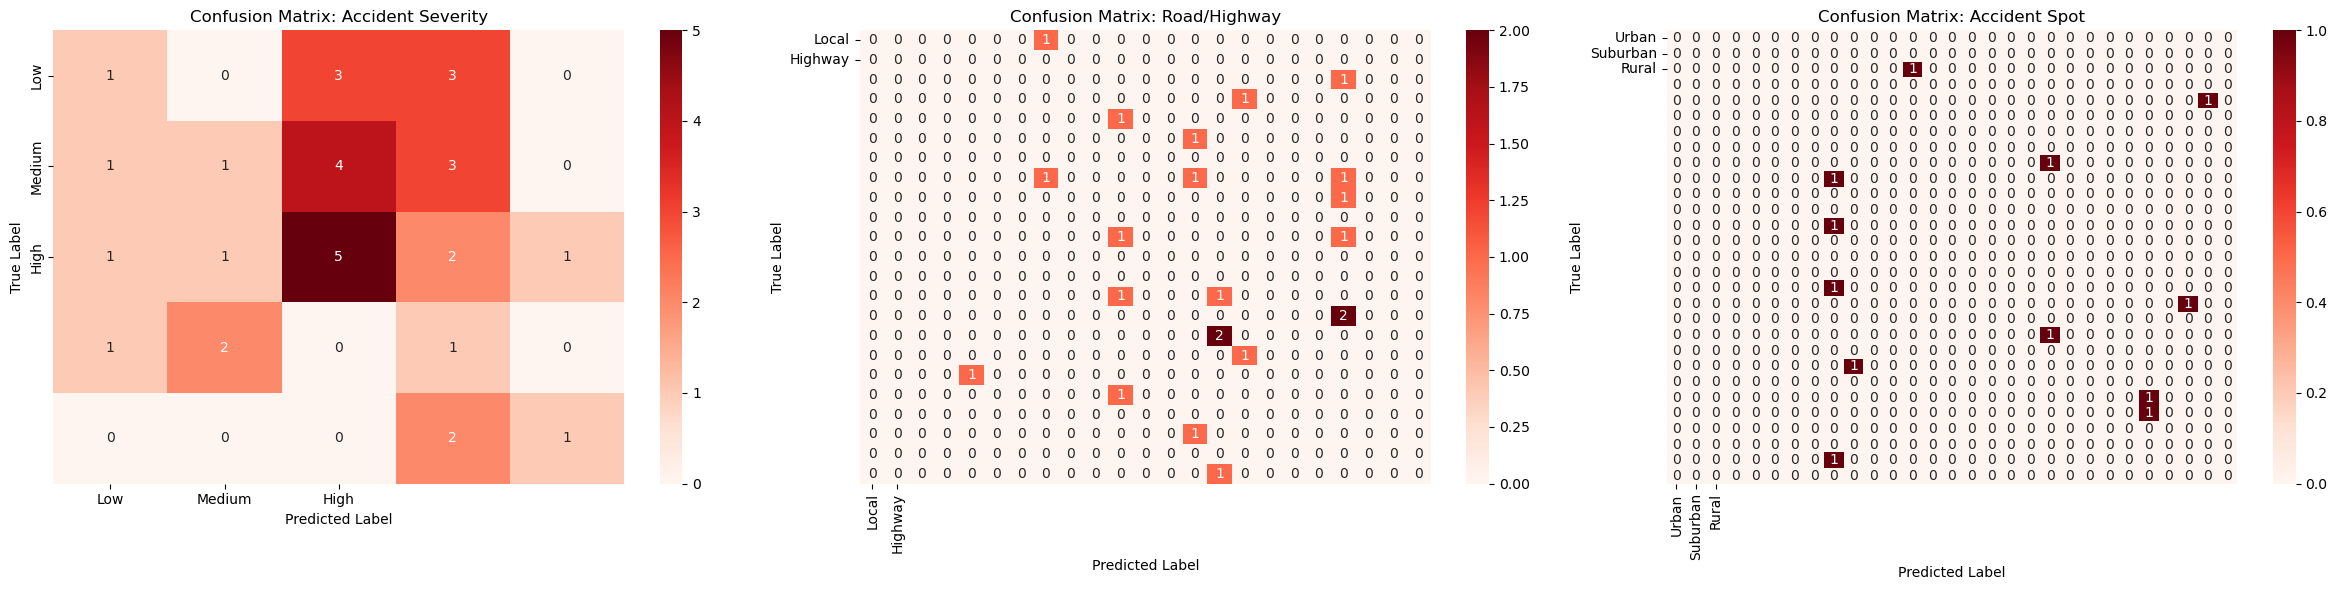

In [14]:
key_mapping = {
    'accident_severity_encoded': 'Accident Severity',
    'Road_Highway_encoded': 'Road/Highway',
    'Accident_Spot_encoded': 'Accident Spot'
}

# Define class names for each target variable
class_names = {
    'accident_severity_encoded': ['Low', 'Medium', 'High'],
    'Road_Highway_encoded': ['Local', 'Highway'],
    'Accident_Spot_encoded': ['Urban', 'Suburban', 'Rural']
}

plt.figure(figsize=(24, 6))  

for idx, (key, display_name) in enumerate(key_mapping.items(), 1):
    plt.subplot(1, 3, idx)
    cm = confusion_matrices[key]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
                xticklabels=class_names[key],
                yticklabels=class_names[key])
    plt.title(f"Confusion Matrix: {display_name}")
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_2040\1234294823.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


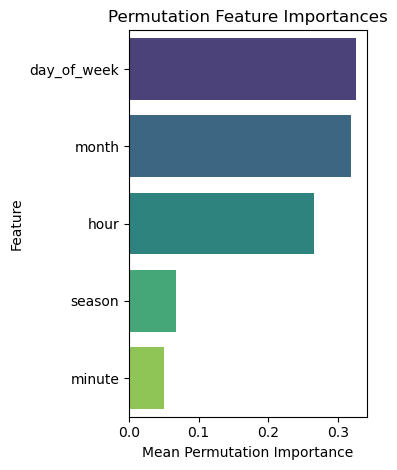

In [15]:
plt.subplot(1, 2, 2)

classifier = model_new.named_steps['classifier']

# Compute permutation importance
result = permutation_importance(model_new, X, y, n_repeats=30, random_state=None, n_jobs=-1)

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

# Plotting the feature importances
sns.barplot(
    x='importance_mean',
    y='feature',
    data=importance_df,
    palette='viridis',
    orient='h'
)
plt.xlabel('Mean Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importances')

plt.tight_layout()
plt.show()



In [16]:
import json
import joblib
import pickle

classifier_step = model_new.named_steps['classifier']

model_params = {}
if isinstance(classifier_step, Pipeline):
    # Access the inner classifier
    inner_classifier = classifier_step.named_steps['multi_clf']  # Replace 'multi_clf' accordingly   
    if isinstance(inner_classifier, MultiOutputClassifier):
        estimators = inner_classifier.estimators_
        model_params['estimators'] = []
        for est in estimators:
            est_params = {}
            if hasattr(est, 'random_state'):
                est_params['random_state'] = est.random_state
            if hasattr(est, 'max_depth'):
                est_params['max_depth'] = est.max_depth
            # Add more parameters as needed
            model_params['estimators'].append(est_params)
    else:
        pass
else:
    # If 'classifier_step' is directly a MultiOutputClassifier
    if isinstance(classifier_step, MultiOutputClassifier):
        estimators = classifier_step.estimators_
        model_params['estimators'] = []
        for est in estimators:
            est_params = {}
            if hasattr(est, 'random_state'):
                est_params['random_state'] = est.random_state
            if hasattr(est, 'max_depth'):
                est_params['max_depth'] = est.max_depth
            # Add more parameters as needed
            model_params['estimators'].append(est_params)
    else:
        if hasattr(classifier_step, 'random_state'):
            model_params['random_state'] = classifier_step.random_state
        if hasattr(classifier_step, 'max_depth'):
            model_params['max_depth'] = classifier_step.max_depth



# Save parameters as JSON
with open('model_params.json', 'w') as f:
    json.dump(model_params, f)

# Save label encoders
joblib.dump(le_severity, 'label_encoder_severity.joblib')
joblib.dump(le_road, 'label_encoder_road.joblib')
joblib.dump(le_accident_spot, 'label_encoder_accident_spot.joblib')

# Save the multi-output model
joblib.dump(model_new, 'multi_estimators_accident_severity_road_accident_spot_model.joblib', protocol=pickle.HIGHEST_PROTOCOL)

print(['multi_estimators_accident_severity_road_accident_spot_model.joblib'])

['multi_estimators_accident_severity_road_accident_spot_model.joblib']
